# Forecasting Tourism Demand in Singapore

## Importing Libraries

In [756]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Collection and Preprocessing

### Importing Dataset

In [757]:
inter_arr = 'data/raw/international_visitor_arrivals.csv'
inter_arr_stay_days = 'data/raw/international_visitor_arrivals_stay_days.csv'
inter_arr_age = 'data/raw/international_visitor_arrivals_age.csv'
hotel_stats = 'data/raw/hotel_statistics.csv'
weather = 'data/raw/weather.csv'
purpose_visit = 'data/raw/purpose_of_visit.xlsx'
spent = 'data/raw/money_spent.xlsx'
holiday_14_22 = 'data/raw/holidays_2014_2022.csv'
holiday_23 = 'data/raw/holidays_2023.csv'
holiday_24 = 'data/raw/holidays_2024.csv'
gdp = 'data/raw/gdp.csv'

inter_arrival_df = pd.read_csv(inter_arr)
inter_arrival_stay_days_df = pd.read_csv(inter_arr_stay_days)
inter_arrival_age_df = pd.read_csv(inter_arr_age)
hotel_stats_df = pd.read_csv(hotel_stats)
weather_df = pd.read_csv(weather)
purpose_visit_df = pd.read_excel(purpose_visit)
spent_df = pd.read_excel(spent)
holiday_14_22_df = pd.read_csv(holiday_14_22)
holiday_23_df = pd.read_csv(holiday_23)
holiday_24_df = pd.read_csv(holiday_24)
gdp_df = pd.read_csv(gdp)

### Converting long to wide format and Cleaning

In [758]:
# Long to Wide convertor function
def wide2Long(_df, value_name, series_name):
    df = _df.melt(id_vars='DataSeries', var_name='date', value_name=value_name)
    df['date'] = pd.to_datetime(df['date'], format="%Y%b")
    df.set_index('date', inplace=True)
    df.rename(columns={
        'DataSeries': series_name
    } ,inplace=True)
    df = df.loc['2018-01-01':]
    return df

def wide2Long_2(_df, value_name, series_name):
    df = _df.melt(id_vars='DataSeries', var_name='date', value_name=value_name)
    df['date'] = pd.to_datetime(df['date'], format="%Y").dt.year
    df.set_index('date', inplace=True)
    df.rename(columns={
        'DataSeries': series_name
    } ,inplace=True)
    df = df.loc['2015':]
    df.index = df.index.sort_values(ascending=False)
    return df

In [759]:
# International Visitor Arrival
inter_arrival_df = wide2Long(inter_arrival_df, 'visitor_arrivals', 'region')
inter_arrival_df['region'] = inter_arrival_df['region'].str.replace('Total International Visitor Arrivals By Inbound Tourism Markets', 'Total')

# International Visitor Arrival Stay Days
inter_arrival_stay_days_df = wide2Long(inter_arrival_stay_days_df, 'visitor_arrivals', 'stay_days')
inter_arrival_stay_days_df['stay_days'] = inter_arrival_stay_days_df['stay_days'].str.replace('Total International Visitor Arrivals', 'Total')

# International Visitor Arrival Age
inter_arrival_age_df = wide2Long(inter_arrival_age_df, 'visitor_arrivals', 'age')

# International Visitor Arrival Gender
inter_arrival_gender_df = inter_arrival_age_df[inter_arrival_age_df['age'].isin(['Males','Females'])]
inter_arrival_age_df = inter_arrival_age_df[~inter_arrival_age_df['age'].isin(['Males','Females'])]

# Hotel Statistics
hotel_stats_df = wide2Long(hotel_stats_df, 'hotels_data', 'hotels_info')

# Weather
weather_df = wide2Long(weather_df, 'weather_data', 'weather_info')

# Purpose of Visit
purpose_visit_df = wide2Long_2(purpose_visit_df, 'count', 'purpose')

# Travel Spent
spent_df = wide2Long_2(spent_df, 'dollar(millions)', 'travel')
spent_df = spent_df.drop(columns=['travel'])

# GDP
gdp_df = wide2Long_2(gdp_df, 'dollar', 'gdp')
gdp_df = gdp_df.drop(columns=['gdp'])

# Holidays
holiday_14_22_df['date'] = pd.to_datetime(holiday_14_22_df['date'], format='%Y-%m-%d')
holiday_23_df['date'] = pd.to_datetime(holiday_23_df['date'], format='%Y-%m-%d')
holiday_24_df['date'] = pd.to_datetime(holiday_24_df['date'], format='%Y-%m-%d')
holidays = pd.concat([holiday_14_22_df, holiday_23_df, holiday_24_df])
holidays = holidays.reset_index(drop=True)


### Converting Data Types

In [760]:
inter_arrival_stay_days_df['visitor_arrivals'] = inter_arrival_stay_days_df['visitor_arrivals'].astype('int')

inter_arrival_age_df = inter_arrival_age_df[inter_arrival_age_df['age'] != 'Not Stated']
inter_arrival_age_df['visitor_arrivals'] = inter_arrival_age_df['visitor_arrivals'].astype('int')

inter_arrival_gender_df['visitor_arrivals'] = inter_arrival_gender_df['visitor_arrivals'].astype('int')

weather_df['weather_data'] = weather_df['weather_data'].astype('float')

### Making Date Index


In [761]:
datasets1 = [
    inter_arrival_stay_days_df, 
    inter_arrival_age_df, 
    hotel_stats_df, 
    weather_df, 
    holidays, 
]

for df in datasets1:
    df = df.reset_index()
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

holidays = holidays.reset_index()
holidays['date'] = pd.to_datetime(holidays['date'])
holidays = holidays.set_index('date')
holidays = holidays.drop(columns='index')

# datasets2 = [
#     purpose_visit_df, 
#     spent_df, 
#     gdp_df
# ]

# for df in datasets2:
#     df = df.reset_index()
#     df['date'] = pd.to_datetime(df['date'], format='%Y')
#     df = df.set_index('date')

gdp_df = gdp_df.reset_index()
gdp_df['date'] = pd.to_datetime(gdp_df['date'], format='%Y')
gdp_df = gdp_df.set_index('date')

spent_df = spent_df.reset_index()
spent_df['date'] = pd.to_datetime(spent_df['date'], format='%Y')
spent_df = spent_df.set_index('date')

purpose_visit_df = purpose_visit_df.reset_index()
purpose_visit_df['date'] = pd.to_datetime(purpose_visit_df['date'], format='%Y')
purpose_visit_df = purpose_visit_df.set_index('date')

## EDA

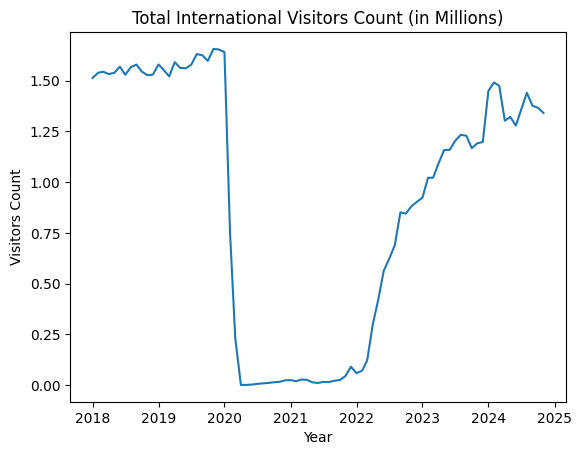

In [762]:
inter_arrival_df_total = inter_arrival_df[inter_arrival_df['region'] == 'Total'].copy()
inter_arrival_df_total['visitor_arrivals'] = inter_arrival_df_total['visitor_arrivals'].astype(float) / 1_000_000

sns.lineplot(x=inter_arrival_df_total.index, y=inter_arrival_df_total['visitor_arrivals'])
plt.title('Total International Visitors Count (in Millions)')
plt.xlabel('Year')
plt.ylabel('Visitors Count')
plt.show()

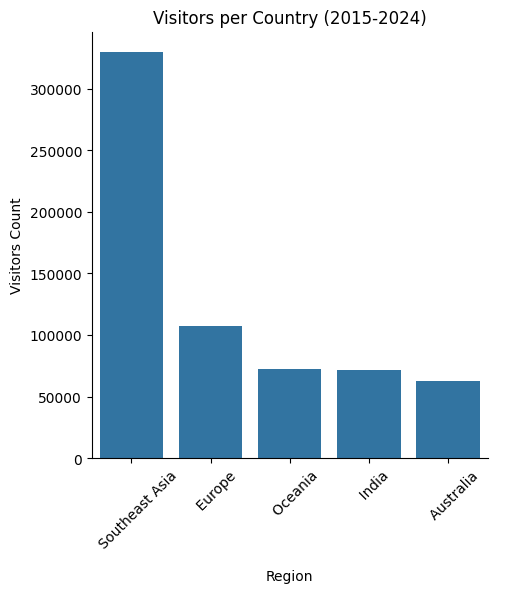

In [763]:
inter_arrival_df_per_country = inter_arrival_df.copy()
inter_arrival_df_per_country = inter_arrival_df_per_country.groupby('region')['visitor_arrivals'].mean().sort_values(ascending=False)
inter_arrival_df_per_country = pd.DataFrame(inter_arrival_df_per_country[inter_arrival_df_per_country.index != 'Total']).iloc[:5,:]

sns.catplot(data=inter_arrival_df_per_country, x='region', y='visitor_arrivals',kind='bar')
plt.xticks(rotation=45)
plt.xlabel('Region')
plt.ylabel('Visitors Count')
plt.title('Visitors per Country (2015-2024)')
plt.show()

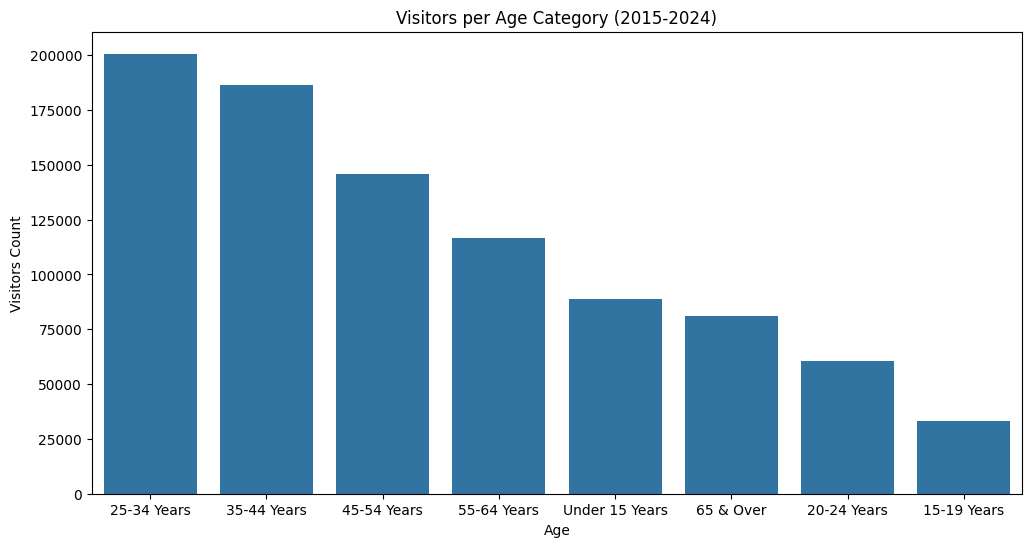

In [764]:
inter_arrival_age_df_group = inter_arrival_age_df.copy()
inter_arrival_age_df_group = inter_arrival_age_df_group.groupby('age')['visitor_arrivals'].mean().sort_values(ascending=False)
inter_arrival_age_df_group = pd.DataFrame(inter_arrival_age_df_group[inter_arrival_age_df_group.index != 'Total'])

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=inter_arrival_age_df_group, x='age', y='visitor_arrivals', ax=ax)
plt.xlabel('Age')
plt.ylabel('Visitors Count')
plt.title('Visitors per Age Category (2015-2024)')
plt.show()

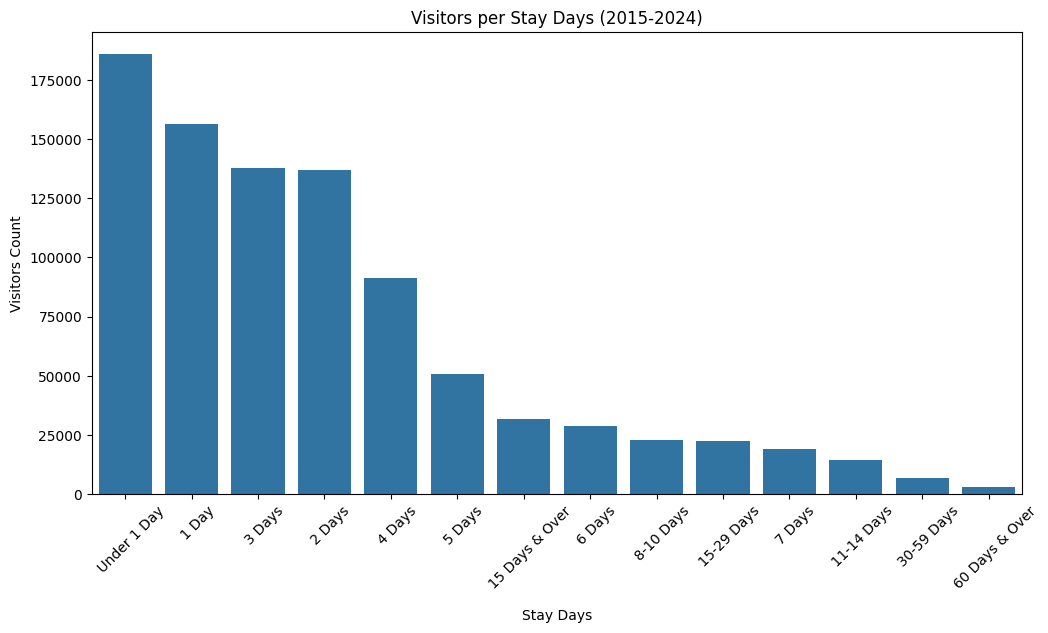

In [765]:
inter_arrival_stay_days_df_group = inter_arrival_stay_days_df.copy()
inter_arrival_stay_days_df_group = inter_arrival_stay_days_df_group.groupby('stay_days')['visitor_arrivals'].mean().sort_values(ascending=False)
inter_arrival_stay_days_df_group = pd.DataFrame(inter_arrival_stay_days_df_group[(inter_arrival_stay_days_df_group.index != 'Total') & (inter_arrival_stay_days_df_group.index != 'Average Length Of Stay')])

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=inter_arrival_stay_days_df_group, x='stay_days', y='visitor_arrivals', ax=ax)
ax.tick_params(axis='x', rotation=45) 
plt.xlabel('Stay Days')
plt.ylabel('Visitors Count')
plt.title('Visitors per Stay Days (2015-2024)')
plt.show()

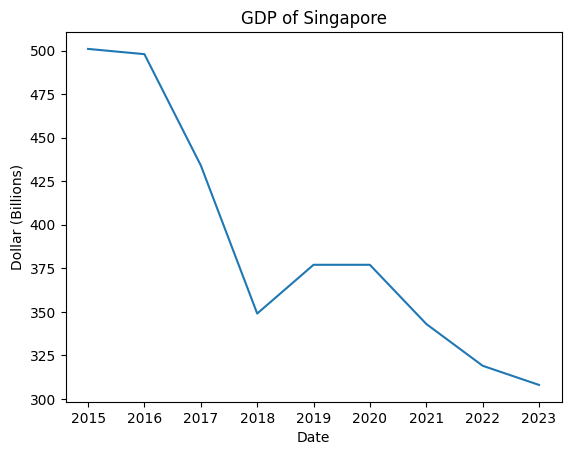

In [766]:
sns.lineplot(x=gdp_df.index, y=gdp_df['dollar']/1000000000)
plt.xlabel('Date')
plt.ylabel('Dollar (Billions)')
plt.title("GDP of Singapore")
plt.show()

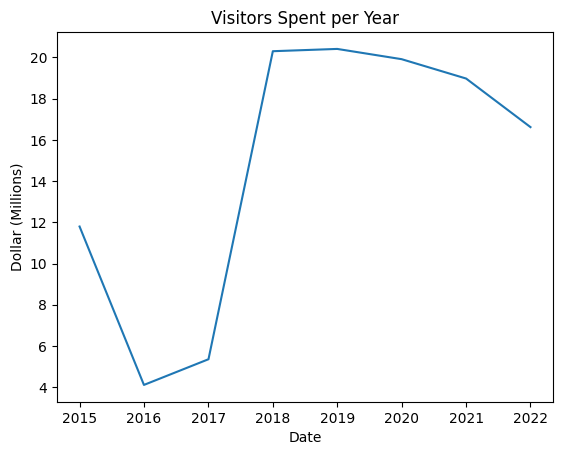

In [767]:
sns.lineplot(x=spent_df.index, y=spent_df['dollar(millions)']/1000)
plt.xlabel('Date')
plt.ylabel('Dollar (Millions)')
plt.title("Visitors Spent per Year")
plt.show()

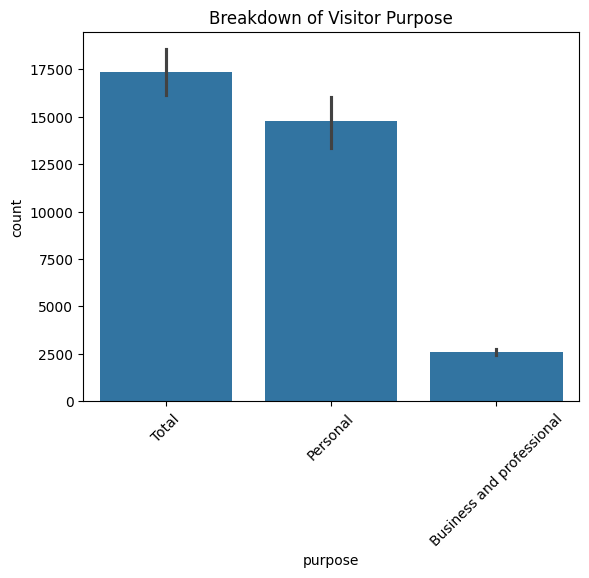

In [768]:
sns.barplot(x="purpose", y="count", data=purpose_visit_df)
plt.title("Breakdown of Visitor Purpose")
plt.xticks(rotation=45)
plt.show()

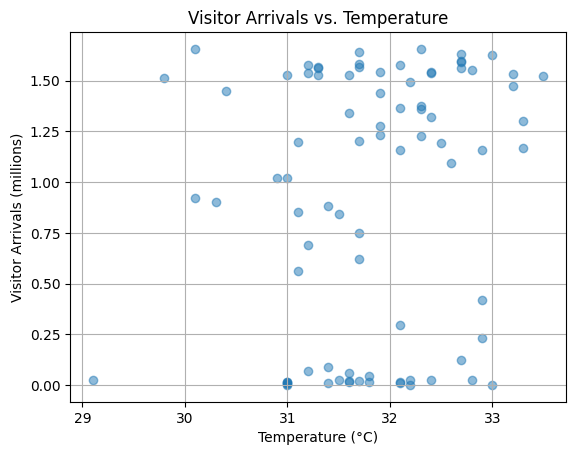

In [769]:
weather_temp_df = weather_df[weather_df['weather_info'] == 'Air Temperature Means Daily Maximum']
inter_arrival_total_df = inter_arrival_df[inter_arrival_df['region'] == 'Total']
merged_df = inter_arrival_total_df.merge(weather_temp_df, on="date")

plt.scatter(merged_df['weather_data'], merged_df['visitor_arrivals']/1000000, alpha=0.5)
plt.xlabel("Temperature (°C)")
plt.ylabel("Visitor Arrivals (millions)")
plt.title("Visitor Arrivals vs. Temperature")
plt.grid()
plt.show()


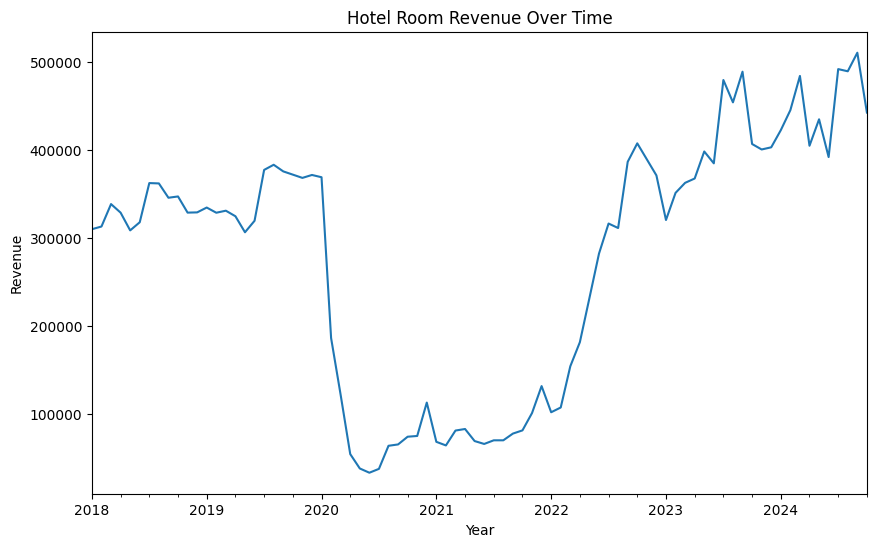

In [770]:
plt.figure(figsize=(10, 6))
hotel_stats_df[hotel_stats_df["hotels_info"] == "Hotel Room Revenue"]["hotels_data"].plot()
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.title("Hotel Room Revenue Over Time")
plt.show()


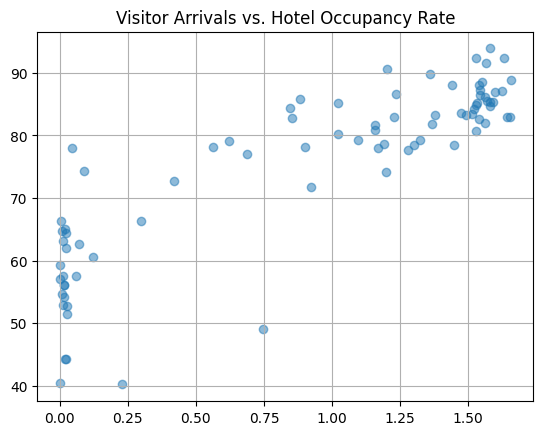

In [771]:
hotel_stats_occupy_df = hotel_stats_df[hotel_stats_df["hotels_info"] == "Standard Average Hotel Occupancy Rate"]
merged_data = pd.merge(hotel_stats_occupy_df, inter_arrival_df_total, left_index=True, right_index=True)
plt.scatter(merged_data["visitor_arrivals"], merged_data["hotels_data"], alpha=0.5)
plt.title("Visitor Arrivals vs. Hotel Occupancy Rate")
plt.grid()
plt.show()

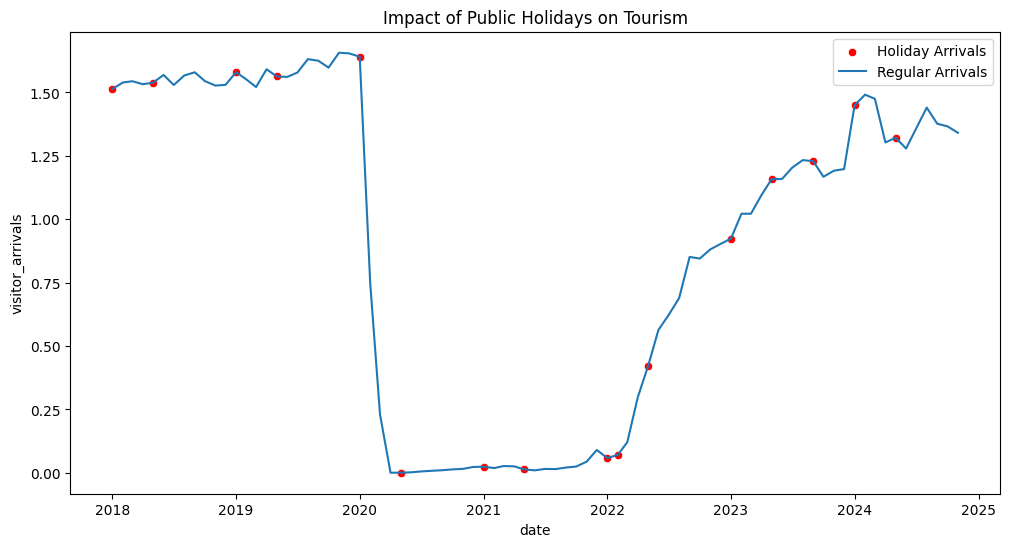

In [772]:
holiday_dates = holidays.index
holiday_arrivals = inter_arrival_df_total.loc[inter_arrival_df_total.index.isin(holiday_dates)]

plt.figure(figsize=(12, 6))
sns.scatterplot(x=holiday_arrivals.index, y=holiday_arrivals["visitor_arrivals"], color="red", label="Holiday Arrivals")
sns.lineplot(x=inter_arrival_df_total.index, y=inter_arrival_df_total["visitor_arrivals"], label="Regular Arrivals")

plt.title("Impact of Public Holidays on Tourism")
plt.legend()
plt.show()

In [773]:
gdp_df

,dollar
date,
2023-01-01,3.080000e+11
2022-01-01,3.190000e+11
2021-01-01,3.430000e+11
2020-01-01,3.770000e+11
2019-01-01,3.770000e+11
2018-01-01,3.490000e+11
2017-01-01,4.340000e+11
2016-01-01,4.980000e+11
2015-01-01,5.010000e+11


In [774]:
inter_arrival_df_total

,region,visitor_arrivals
date,,
2024-11-01,Total,1.340888
2024-10-01,Total,1.366325
2024-09-01,Total,1.376504
2024-08-01,Total,1.439978
2024-07-01,Total,1.358291
...,...,...
2018-05-01,Total,1.538617
2018-04-01,Total,1.532292
2018-03-01,Total,1.543933


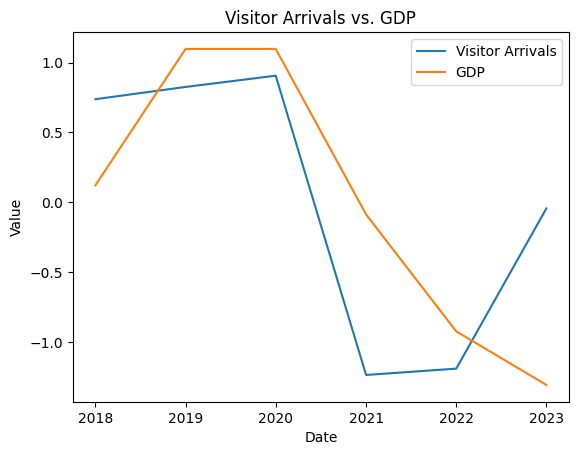

In [778]:
merged_gdp = pd.merge(inter_arrival_df_total, gdp_df, left_index=True, right_index=True)
mean_arrivals = merged_gdp['visitor_arrivals'].mean()
std_arrivals = merged_gdp['visitor_arrivals'].std()

mean_gdp = merged_gdp['dollar'].mean()
std_gdp = merged_gdp['dollar'].std()

merged_gdp['std_visitor_arrivals'] = (merged_gdp['visitor_arrivals'] - mean_arrivals) / std_arrivals
merged_gdp['std_dollar'] = (merged_gdp['dollar'] - mean_gdp) / std_gdp

plt.plot(merged_gdp.index, merged_gdp['std_visitor_arrivals'], label='Visitor Arrivals')
plt.plot(merged_gdp.index, merged_gdp['std_dollar'], label='GDP')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Visitor Arrivals vs. GDP')
plt.legend()
plt.show()